In [1]:
import random

def file_reader_movie_lens_rating(path='', sep='::'):
    """ read in rating dataset from movie lens

    :param path:
    :param sep:
    :return:
    """
    f = open(file=path, mode='r')
    if sep==',':
        f.readline() # skip header
    rats = []
    f_line = f.readline()
    while True:
        if not f_line:
            break
        # parse
        user, item, rating, timestamp = f_line.strip().split(sep)
        rats.append([user, item, rating])

        f_line = f.readline()

    return rats

def obj_mapping(ratings):
    """ Read in rating data into get mapper

    :param rats:
    :return:
    """
    def obj2ix(obj):
        obj = sorted(list(set(obj)), key=lambda x: int(x))
        ix = list(range(len(obj)))
        return dict(zip(obj, ix)), dict(zip(ix, obj))

    users, items, _ = zip(*ratings)
    user2ix, ix2user = obj2ix(users)
    item2ix, ix2item = obj2ix(items)

    return user2ix, ix2user, item2ix, ix2item

rats = file_reader_movie_lens_rating(path='./data/ml-small/ratings.csv', sep=',')
# rats = file_reader_movie_lens_rating(path='./data/ml-1m/ratings.dat', sep='::')

user2ix, ix2user, item2ix, ix2item = obj_mapping(rats)

num_user = len(user2ix.keys())
num_item = len(item2ix.keys())

print(f'Users: {num_user}, Items: {num_item}. Sparsity: {1-len(rats)/num_user/num_item}')

Users: 610, Items: 9724. Sparsity: 0.9830003169443864


In [2]:
def rating_train_test_parser(ratings, perc=0.2, test_filter=True):
    """ parse rating into training and testing set

    :param ratings: list
        A list of triplet denoting users' rating records on movies

    :param perc: float
        The percentage that should is divided into testing set

    :param test_filter: bool
        If we remove the rating record from testing set if the rating is smaller than 3

    :return rat_train_dict, rat_test_dict: dict
         A dictionary of users rating on items.
         {userix: {movieix: rating, ...}, ...}
    """
    sep_counter = int(1/perc)
    rat_train_dict = dict()
    rat_test_dict = dict()
    for ix, rat in enumerate(ratings):
        u, i, r = rat
        uix = user2ix[u]
        iix = item2ix[i]
        r = float(r)
        if ix % sep_counter == 0:
            # skip the record if its rating is lower than 3
            if test_filter and r<3:
                continue
            if uix not in rat_test_dict:
                rat_test_dict[uix] = {}
            rat_test_dict[uix][iix] = r
        else:
            if uix not in rat_train_dict:
                rat_train_dict[uix] = {}
            rat_train_dict[uix][iix] = r

    users_of_interest = list(rat_test_dict.keys())
    ratings_of_interest = [rat_train_dict[user] for user in users_of_interest]
    rat_train_dict = dict(zip(users_of_interest, ratings_of_interest))

    return rat_train_dict, rat_test_dict

rat_train_dict, rat_test_dict = rating_train_test_parser(rats)

print(f'User reduced from {len(user2ix.keys())} to {len(rat_train_dict.keys())}')

User reduced from 610 to 607


In [3]:
def pairwise_loader_even_prob(training_dict, items, user_size, pos_size=1, neg_size=1, batch_size=128):
    from random import choices, choice
    from torch.utils.data import DataLoader

    all_item_set = set(items.keys())

    train_data = []
    for _ in range(user_size):
        user = choice(list(training_dict.keys()))
        pos_cands = list(training_dict[user].keys())
        pos_items = choices(pos_cands, k=pos_size)
        # Using Negative Sampling
        if neg_size!=0:
            neg_cands = list(all_item_set-set(pos_items))
            neg_set_size = len(pos_items)*neg_size
            neg_items = choices(neg_cands, k=neg_set_size)
            pos_items *= neg_size
            target_user = [user] * neg_size * len(pos_items)
            train_data.extend(zip(target_user, pos_items, neg_items))
        # Not Using Negative Sampling
        else:
            target_user = [user] * len(pos_items)
            train_data.extend(zip(target_user, pos_items))

    train_data_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    return train_data_loader

In [4]:
def list_loader_even_prob(training_dict, items, user_size, pos_size=1, neg_size=1, batch_size=128):
    from random import choices, choice
    from torch import tensor
    from torch.utils.data import DataLoader

    all_item_set = set(items.keys())

    train_data = []
    for _ in range(user_size):
        user = choice(list(training_dict.keys()))
        pos_cands = list(training_dict[user].keys())
        pos_items = choices(pos_cands, k=pos_size)
        # Using Negative Sampling
        if neg_size!=0:
            neg_cands = list(all_item_set-set(pos_items))
            neg_set_size = len(pos_items)*neg_size
            neg_items = choices(neg_cands, k=neg_set_size)
            neg_items = [neg_items[i:i+neg_size] for i in range(0,len(neg_items), neg_size)]
            target_user = [user] * len(pos_items)

            # return
            train_data.extend(zip(target_user, pos_items, tensor(neg_items)))
        # Not Using Negative Sampling
        else:
            target_user = [user] * len(pos_items)
            train_data.extend(zip(target_user, pos_items))

    train_data_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    return train_data_loader

dl = list_loader_even_prob(
    rat_train_dict
    , ix2item
    , user_size=1
    , pos_size=2
    , neg_size=4
)
dl

In [5]:
# modeling svd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor

class FunkSVD(nn.Module):
    """ Matrix Factorization based method, referring to FunkSVD
    """
    def __init__(self, n_user, n_item, k_dim, negative_sampling:bool):
        super(FunkSVD, self).__init__()
        self.k_dim=k_dim
        self.negative_sampling = negative_sampling # if training with negative sampling
        # embeddings of interest
        self.embedding_user = nn.Embedding(n_user, k_dim)
        self.embedding_item = nn.Embedding(n_item, k_dim)
        # init param
        self.embedding_user.weight.data.uniform_(0, 1)
        self.embedding_item.weight.data.uniform_(0, 1)

    def forward(self, user, pos_item, neg_item=None):
        pos_rat = (self.embedding_user(user)*self.embedding_item(pos_item)).sum(1)

        if not self.negative_sampling:
            return -pos_rat

        neg_emb = self.embedding_item(neg_item)
        user_emb = self.embedding_user(user).view(-1, self.k_dim, 1) # transform shape
        neg_rat = -(torch.bmm(neg_emb, user_emb)).view(-1) # use bmm to calcualte score

        return torch.cat((pos_rat, neg_rat), 0) # concat positive and negative ratings

    def get_user_embedding(self, user):
        return self.embedding_user(user).data

    def get_item_embedding(self, item):
        return self.embedding_item(item).data

def MF_loss(preds):
    return -F.logsigmoid(preds).sum()

In [6]:
def train_model(model, ratings, items, n_epochs, opt_fn, user_size, pos_size, neg_size=0, negative_sampling=True, method='list', cuda=True):

    import time
    from torch import autograd, LongTensor
    import numpy as np

    assert method in ['list', 'pairwise'], 'Invalid method %s' % method
    loader = list_loader_even_prob if method == 'list' else pairwise_loader_even_prob

    device = torch.device('cuda' if cuda==True else 'cpu')

    if cuda:
        model.cuda()

    losses = []

    t0 = time.time()
    for epoch in range(n_epochs):
        train_data = loader(
            ratings
            , items
            , user_size=user_size
            , pos_size=pos_size
            , neg_size=neg_size)

        for i, batch in enumerate(train_data):
            if not negative_sampling:
                user, pos_item = batch
            else:
                user, pos_item, neg_item = batch

            model.zero_grad()

            # variablize
            user = autograd.Variable(LongTensor(user)).to(device)
            pos_item = autograd.Variable(LongTensor(pos_item)).to(device)
            if negative_sampling:
                neg_item = autograd.Variable(LongTensor(neg_item)).to(device)

            preds = model(user=user, pos_item=pos_item)\
                        .mean()\
                if not negative_sampling else \
                    model(user=user, pos_item=pos_item, neg_item=neg_item)\
                        .mean()

            loss = MF_loss(preds)

            loss.backward()
            opt_fn.step()
            losses.append(loss.data.to(device).tolist())

        if epoch % 10 == 0:
            t1=time.time()
            print(f'Epoch: {epoch}, Time: {round(t1-t0,2)}, /Average loss {np.mean(losses[-10:]).round(5)}')
            t0=time.time()

    return model, losses

In [35]:
import torch.optim as optim

cuda = torch.cuda.is_available()
n_users = len(user2ix)
n_items = len(item2ix)
embed_size = 32

num_epochs = 512 # Max number of training epochs
lr = 0.001 # Set the learning rate
reg = 0.01
svd_raw = FunkSVD(n_users, n_items, embed_size, negative_sampling=False)
opt_fn = optim.SGD(svd_raw.parameters(), lr=lr, weight_decay=reg, momentum=0.01) # Select an optimizer

svd_raw, losses_r = train_model(
    svd_raw
    , ratings = rat_train_dict
    , items = ix2item
    , n_epochs = num_epochs
    , opt_fn = opt_fn
    , user_size = 512
    , pos_size = 4
    , negative_sampling=False
    , cuda=True)

Epoch: 0, Time: 0.04, /Average loss 8.11447
Epoch: 10, Time: 0.36, /Average loss 7.99066
Epoch: 20, Time: 0.43, /Average loss 7.98632
Epoch: 30, Time: 0.41, /Average loss 7.91744
Epoch: 40, Time: 0.39, /Average loss 7.92005
Epoch: 50, Time: 0.47, /Average loss 7.85637
Epoch: 60, Time: 0.36, /Average loss 7.92803
Epoch: 70, Time: 0.35, /Average loss 7.81178
Epoch: 80, Time: 0.34, /Average loss 7.79714
Epoch: 90, Time: 0.37, /Average loss 7.73227
Epoch: 100, Time: 0.37, /Average loss 7.68872
Epoch: 110, Time: 0.44, /Average loss 7.62631
Epoch: 120, Time: 0.41, /Average loss 7.69523
Epoch: 130, Time: 0.43, /Average loss 7.69496
Epoch: 140, Time: 0.89, /Average loss 7.6718
Epoch: 150, Time: 0.47, /Average loss 7.66867
Epoch: 160, Time: 1.29, /Average loss 7.56543
Epoch: 170, Time: 0.49, /Average loss 7.52695
Epoch: 180, Time: 0.45, /Average loss 7.47177
Epoch: 190, Time: 0.38, /Average loss 7.46783
Epoch: 200, Time: 0.37, /Average loss 7.39343
Epoch: 210, Time: 0.4, /Average loss 7.53881
E

In [36]:
import torch.optim as optim

cuda = torch.cuda.is_available()
n_users = len(user2ix)
n_items = len(item2ix)
embed_size = 32

num_epochs = 512 # Max number of training epochs
lr = 0.001 # Set the learning rate
reg = 0.01
svd_p = FunkSVD(n_users, n_items, embed_size, negative_sampling=False)
opt_fn = optim.SGD(svd_p.parameters(), lr=lr, weight_decay=reg, momentum=0.01) # Select an optimizer

svd_p, losses_p = train_model(
    svd_p
    , ratings = rat_train_dict
    , items = ix2item
    , n_epochs = num_epochs
    , opt_fn = opt_fn
    , user_size = 512
    , pos_size = 4
    , neg_size = 4
    , negative_sampling=True
    , cuda=True)

Epoch: 0, Time: 0.16, /Average loss 7.97259
Epoch: 10, Time: 1.78, /Average loss 8.02651
Epoch: 20, Time: 1.74, /Average loss 7.85711
Epoch: 30, Time: 1.64, /Average loss 7.90319
Epoch: 40, Time: 1.83, /Average loss 7.86886
Epoch: 50, Time: 2.06, /Average loss 7.76481
Epoch: 60, Time: 1.81, /Average loss 7.8503
Epoch: 70, Time: 1.6, /Average loss 7.73198
Epoch: 80, Time: 1.63, /Average loss 7.79281
Epoch: 90, Time: 1.5, /Average loss 7.7726
Epoch: 100, Time: 1.82, /Average loss 7.64244
Epoch: 110, Time: 1.85, /Average loss 7.6068
Epoch: 120, Time: 1.52, /Average loss 7.68963
Epoch: 130, Time: 1.5, /Average loss 7.55816
Epoch: 140, Time: 1.59, /Average loss 7.66498
Epoch: 150, Time: 1.9, /Average loss 7.53237
Epoch: 160, Time: 1.67, /Average loss 7.47308
Epoch: 170, Time: 1.57, /Average loss 7.44137
Epoch: 180, Time: 1.49, /Average loss 7.4169
Epoch: 190, Time: 1.52, /Average loss 7.42993
Epoch: 200, Time: 2.06, /Average loss 7.4222
Epoch: 210, Time: 1.63, /Average loss 7.35579
Epoch: 2

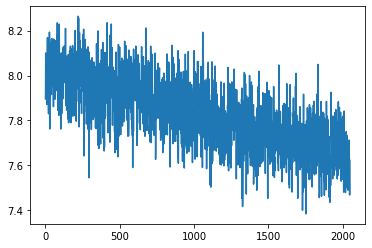

In [9]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(losses_p))), losses_p)

In [37]:
from torch import LongTensor
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import time

cuda = torch.cuda.is_available()
n_users = len(user2ix)
n_items = len(item2ix)
embed_size = 32

num_epochs = 512 # Max number of training epochs
lr = 0.01 # Set the learning rate
reg = 0.01
svd_l = FunkSVD(n_users, n_items, embed_size, negative_sampling=True)
opt_fn = optim.SGD(svd_l.parameters(), lr=lr, weight_decay=reg, momentum=0.01) # Select an optimizer

svd_l, losses_l = train_model(
    svd_l
    , ratings = rat_train_dict
    , items = ix2item
    , n_epochs = num_epochs
    , opt_fn = opt_fn
    , user_size = 512
    , pos_size = 4
    , neg_size = 4
    , negative_sampling=True
    , method = 'list'
    , cuda = True
)

Epoch: 0, Time: 0.27, /Average loss 4.77803
Epoch: 10, Time: 1.9, /Average loss 4.62534
Epoch: 20, Time: 1.6, /Average loss 4.49823
Epoch: 30, Time: 1.65, /Average loss 4.32028
Epoch: 40, Time: 1.82, /Average loss 4.14279
Epoch: 50, Time: 1.82, /Average loss 4.05756
Epoch: 60, Time: 1.67, /Average loss 3.93076
Epoch: 70, Time: 1.58, /Average loss 3.82722
Epoch: 80, Time: 1.76, /Average loss 3.66389
Epoch: 90, Time: 2.12, /Average loss 3.53765
Epoch: 100, Time: 2.3, /Average loss 3.40994
Epoch: 110, Time: 1.78, /Average loss 3.32647
Epoch: 120, Time: 1.72, /Average loss 3.19875
Epoch: 130, Time: 1.72, /Average loss 3.12291
Epoch: 140, Time: 2.03, /Average loss 2.98267
Epoch: 150, Time: 2.23, /Average loss 2.94595
Epoch: 160, Time: 2.08, /Average loss 2.83065
Epoch: 170, Time: 1.78, /Average loss 2.7457
Epoch: 180, Time: 1.85, /Average loss 2.65016
Epoch: 190, Time: 1.66, /Average loss 2.57346
Epoch: 200, Time: 1.78, /Average loss 2.49464
Epoch: 210, Time: 1.59, /Average loss 2.42793
Epo

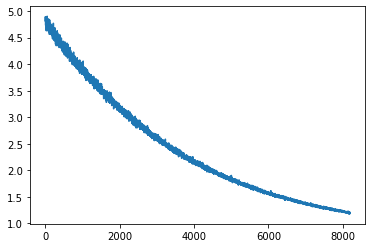

In [38]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(losses_l))), losses_l)

In [39]:
svd_raw = svd_raw.to('cpu')
svd_p = svd_p.to('cpu')
svd_l = svd_l.to('cpu')

In [13]:
test_sizes = []
for user in testing_candidate:
    test_sizes.append(len(testing_candidate[user]))

NameError: name 'testing_candidate' is not defined

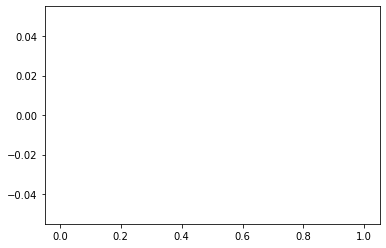

In [14]:
plt.hist(test_sizes)

plt.show()

测试方法为：在集合【去除训练item的物品集】中预测用户对商品的评分

In [40]:
def generate_testing_candidates(rating_train, items):
    items_set = set(list(items.keys()))
    testing_cand = {}
    for user in rating_train:
        testing_cand[user] = list(items_set-set(rating_train[user].keys()))
    return testing_cand

testing_candidates = generate_testing_candidates(rat_train_dict, ix2item)

In [41]:
def predict_recommendation(model, test_cands):
    from torch import tensor

    predict = {}
    for user in test_cands:
        items = test_cands[user]
        # dot product as estimation of rating
        pred = model.embedding_user(tensor([user])) \
               @ model.embedding_item(tensor(items)).T
        pred_ix = torch.argsort(-pred)
        predict[user] = [items[ix] for ix in pred_ix[0]]

    return predict

pred_dict_raw = predict_recommendation(svd_raw, testing_candidates)
pred_dict_p = predict_recommendation(svd_p, testing_candidates)
pred_dict_l = predict_recommendation(svd_l, testing_candidates)


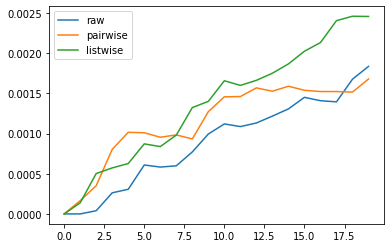

In [52]:
"""
Metric: https://towardsdatascience.com/ranking-evaluation-metrics-for-recommender-systems-263d0a66ef54
"""

def _f1(k, test, predict):
    """ Compute f1 score for each user

    :param k: int
    :param test: list of int
    :param predict: list of int
    :return tp_value: float
    """
    max_eval_size = min(k, len(predict)) # in case user has little candidate item
    tp = 0
    for i in range(max_eval_size):
        if predict[i] in test:
            tp += 1
    return 2*tp/(max_eval_size + len(test))


def f1_ak_k(k, test_dict, pred_dict):
    res = []
    for user in test_dict:
        res.append(_f1(k, test_dict[user], pred_dict[user]))
    return sum(res)/len(test_dict)

k = 20
f1_raw = [f1_ak_k(ki, rat_test_dict, pred_dict_raw) for ki in range(k)]
f1_p = [f1_ak_k(ki, rat_test_dict, pred_dict_p) for ki in range(k)]
f1_l = [f1_ak_k(ki, rat_test_dict, pred_dict_l) for ki in range(k)]

plt.plot(list(range(k)), f1_raw, label='raw')
plt.plot(list(range(k)), f1_p, label='pairwise')
plt.plot(list(range(k)), f1_l, label='listwise')

plt.legend()

plt.show()

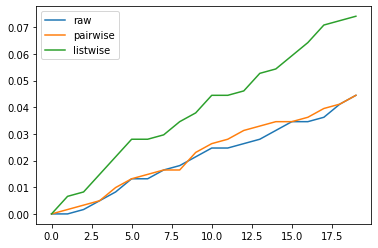

In [67]:
def _hr(k, test, pred):
    if isinstance(pred, dict):
        pred = list(pred.keys())

    if k - len(set(pred[:k])-set(test)) > 0:
        return 1
    else:
        return 0

def hit_rate_at_k(k, test_dict, pred_dict):
    res = []
    for user in test_dict:
        res.append(_hr(k, list(test_dict[user]), pred_dict[user]))
    return sum(res)/len(test_dict)


k = 20
hr_raw = [hit_rate_at_k(ki, rat_test_dict, pred_dict_raw) for ki in range(k)]
hr_p = [hit_rate_at_k(ki, rat_test_dict, pred_dict_p) for ki in range(k)]
hr_l = [hit_rate_at_k(ki, rat_test_dict, pred_dict_l) for ki in range(k)]

plt.plot(list(range(k)), hr_raw, label='raw')
plt.plot(list(range(k)), hr_p, label='pairwise')
plt.plot(list(range(k)), hr_l, label='listwise')

plt.legend()

plt.show()

In [63]:
pred_dict_raw[0][:2]

[1919, 5312]

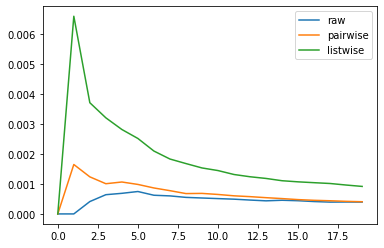

In [58]:
def _map(k, test, pred):
    if isinstance(pred, dict):
        pred = list(pred.keys())

    if not k:
        return 0

    max_eval_size = min(k, len(pred))
    x, s = 0, 0
    for i in range(max_eval_size):
        if pred[i] in test:
            x += 1
            s += x/(i+1)

    return s/max_eval_size # average precision

def map_at_k(k, test_dict, pred_dict):
    res = []
    for user in test_dict:
        res.append(_map(k, list(test_dict[user]), pred_dict[user]))
    # mean of average precision
    return sum(res)/len(test_dict)

k = 20
map_raw = [map_at_k(ki, rat_test_dict, pred_dict_raw) for ki in range(k)]
map_p = [map_at_k(ki, rat_test_dict, pred_dict_p) for ki in range(k)]
map_l = [map_at_k(ki, rat_test_dict, pred_dict_l) for ki in range(k)]

plt.plot(list(range(k)), map_raw, label='raw')
plt.plot(list(range(k)), map_p, label='pairwise')
plt.plot(list(range(k)), map_l, label='listwise')

plt.legend()

plt.show()

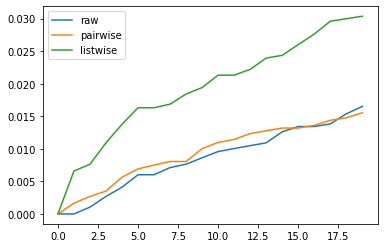

In [68]:
def _dcg(score):
    if len(score)==0:
        return 0

    from math import log
    dcg = 0
    for ix, score_i in enumerate(score):
        if score_i != 0:
            dcg += score_i / log(ix+2, 2)
    return dcg

def _ndcg(k, test, pred, use_score):
    if isinstance(pred, dict) and use_score:
        score = [test[pred_i] if pred_i in test else 0
                 for pred_i in pred[:k]]
    else:
        score = [1 if pred_i in test else 0
                 for pred_i in pred[:k]]

    return _dcg(score)

def ndcg(k, test, predict, use_score=True):
    res = []
    for user in test:
        res.append(_ndcg(k, test[user], predict[user], use_score))
    return sum(res) / len(test)

k = 20
ndcg_raw = [ndcg(ki, rat_test_dict, pred_dict_raw) for ki in range(k)]
ndcg_p = [ndcg(ki, rat_test_dict, pred_dict_p) for ki in range(k)]
ndcg_l = [ndcg(ki, rat_test_dict, pred_dict_l) for ki in range(k)]

plt.plot(list(range(k)), ndcg_raw, label='raw')
plt.plot(list(range(k)), ndcg_p, label='pairwise')
plt.plot(list(range(k)), ndcg_l, label='listwise')

plt.legend()

plt.show()